<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/MobileNet%20final/WOTL%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, models, optimizers
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 97% 156M/161M [00:01<00:00, 106MB/s]
100% 161M/161M [00:01<00:00, 113MB/s]


In [ ]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [ ]:
dataset_dir = '/content/data'

In [ ]:
print(os.listdir(dataset_dir))

['Blight', 'Healthy', 'Gray_Leaf_Spot', 'Common_Rust']


In [ ]:
IMAGE_SIZE_mobilenet = 224

In [ ]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [ ]:
X = []
Z = []

In [ ]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:05<00:00, 200.01it/s]


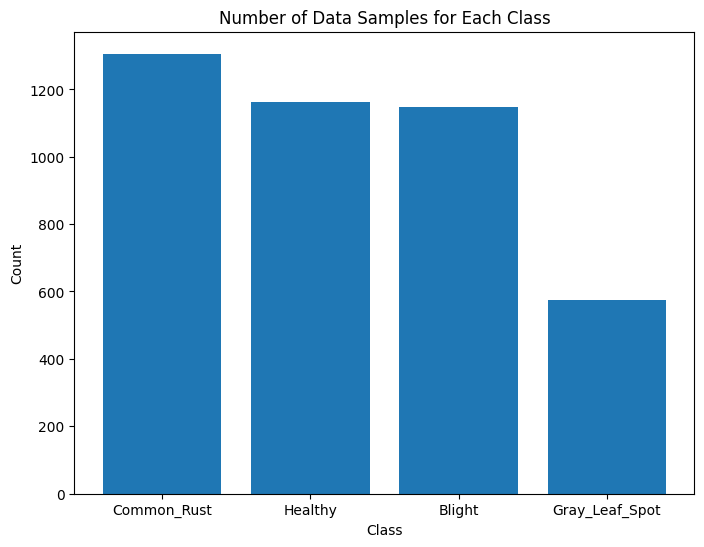

In [ ]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

X = np.array(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [ ]:
NUM_CLASSES = 4
LEARNING_RATE = 1e-4

# Fungsi untuk membuat arsitektur MobileNet
def build_mobilenet(input_shape, num_classes):
    model = models.Sequential()

    # Conv block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU(6.))

    # Depthwise Separable Convolution blocks
    def depthwise_separable_conv(filters, strides):
        model.add(layers.DepthwiseConv2D((3, 3), padding='same', strides=strides, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU(6.))
        model.add(layers.Conv2D(filters, (1, 1), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU(6.))

    depthwise_separable_conv(64, (1, 1))
    depthwise_separable_conv(128, (2, 2))
    depthwise_separable_conv(128, (1, 1))
    depthwise_separable_conv(256, (2, 2))
    depthwise_separable_conv(256, (1, 1))
    depthwise_separable_conv(512, (2, 2))
    for _ in range(5):
        depthwise_separable_conv(512, (1, 1))
    depthwise_separable_conv(1024, (2, 2))
    depthwise_separable_conv(1024, (1, 1))

    # Fully connected layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Buat model MobileNet tanpa transfer learning
model_mobilenet = build_mobilenet(input_shape=(IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet, 3), num_classes=NUM_CLASSES)

# Kompilasi model
model_mobilenet.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model_mobilenet.summary()

history = model_mobilenet.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      864       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 224, 224, 32)      288       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                        

27/27 [==============================] - 3s 106ms/step


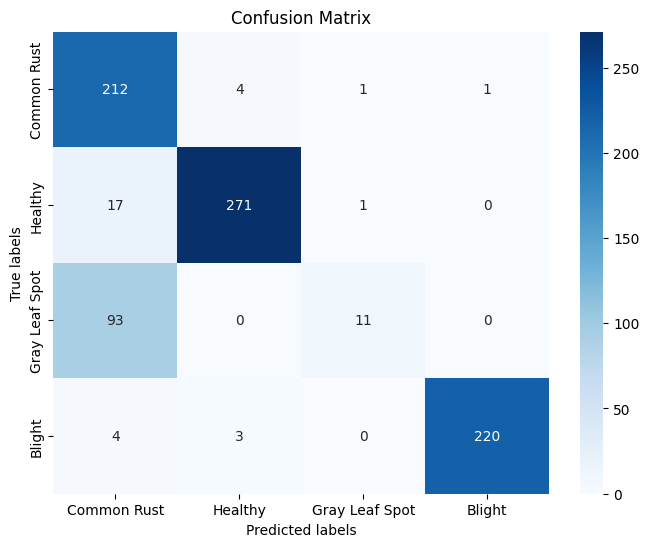


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       218
           1       0.97      0.94      0.96       289
           2       0.85      0.11      0.19       104
           3       1.00      0.97      0.98       227

    accuracy                           0.85       838
   macro avg       0.87      0.75      0.73       838
weighted avg       0.88      0.85      0.82       838



In [ ]:
Y_pred = model_mobilenet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'], yticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=1):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size] + [dim for dim in model.input.shape[1:]], model.input.dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

# Calculate FLOPs
flops = get_flops(model_mobilenet)
print(f"FLOPs: {flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 4541939736
